In [1]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import time
import copy
import cv2
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(0)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

!unzip drive/MyDrive/Data_new.zip

drive.flush_and_unmount()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  drive/MyDrive/Data_new.zip
replace Data_new/images_original/blues/blues00000.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [3]:
# df = pd.read_csv("Data/features_30_sec.csv")
df = pd.read_csv("features_30_sec.csv")
df = df[['filename','label']]

In [4]:
df = df[df['filename'] != "jazz.00054.wav"]
df = df.reset_index()
df.pop('index')

0        0
1        1
2        2
3        3
4        4
      ... 
994    994
995    995
996    996
997    997
998    998
Name: index, Length: 999, dtype: int64

In [5]:
class_name = {}
n = 0
for i in df['label'].unique():
    class_name[i] = n
    n+=1
num_classes = n

In [6]:
df['label'] = df['label'].map(class_name)

In [7]:
for i in range(len(df)):
    temp = df['filename'][i].split(".")
    df['filename'][i] = "Data_new/images_original/" + temp[0] + "/" + temp[0] + temp[1] + ".png"

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
train, test = train_test_split(df, test_size=0.20, random_state=42, stratify = df['label'])
test, val = train_test_split(test, test_size=0.50, random_state=42, stratify = test['label'])

In [9]:
print(sorted(list(test.index)))

[21, 23, 52, 57, 59, 63, 74, 82, 86, 90, 104, 111, 122, 132, 133, 134, 140, 143, 164, 171, 210, 215, 218, 223, 252, 254, 255, 267, 269, 289, 303, 307, 318, 321, 326, 347, 360, 363, 368, 385, 400, 408, 411, 412, 451, 457, 482, 488, 492, 498, 522, 523, 533, 535, 557, 572, 573, 574, 589, 590, 599, 601, 611, 637, 643, 656, 665, 670, 688, 697, 699, 709, 725, 731, 747, 753, 763, 784, 795, 798, 806, 814, 823, 825, 848, 853, 859, 865, 873, 893, 904, 919, 922, 924, 951, 953, 957, 962, 968, 994]


In [10]:
dataset_sizes = {'train': len(train), 'test': len(test), 'val': len(val)}
print(dataset_sizes)

{'train': 799, 'test': 100, 'val': 100}


In [11]:
class GenreDataset(Dataset):
    """Genre dataset."""

    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.csv = csv_file
        self.transform = transform

    def __len__(self):
        return len(self.csv)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.csv.iloc[idx, 0]
        image = cv2.imread(img_name,cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = np.expand_dims(image, axis=-1)
        details = self.csv.iloc[idx, 1:]
        sample = {'image': image, 'label': details[0]}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [12]:
class PreProcessing(object):

    def __init__(self):
        pass

    def __call__(self, sample):
        image, turtle_id = sample['image'], sample['label']
        h, w = image.shape[:2]
        
        ### ADD PREPROCESSING CODE HERE
        
        return [torch.Tensor(image.transpose(2,0,1)), turtle_id]

In [13]:
train_transformed_dataset = GenreDataset(csv_file=train,
                                               transform=transforms.Compose([
                                               PreProcessing()
                                           ]))
test_transformed_dataset = GenreDataset(csv_file=test,
                                               transform=transforms.Compose([
                                               PreProcessing()
                                           ]))
val_transformed_dataset = GenreDataset(csv_file=val,
                                               transform=transforms.Compose([
                                               PreProcessing()
                                           ]))

In [14]:
dataloaders = {'train' : DataLoader(train_transformed_dataset, batch_size=16,
                        shuffle=True, num_workers=0),
              'test' : DataLoader(test_transformed_dataset, batch_size=8,
                        shuffle=True, num_workers=0),
              'val' : DataLoader(val_transformed_dataset, batch_size=16,
                        shuffle=True, num_workers=0)}

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [16]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, patience=5):
    losses = {'train':[], 'val':[]}
    accuracies = {'train':[], 'val':[]}

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    stop_trigger = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # inputs = inputs.type(torch.DoubleTensor)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs.float())
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
          
          
            losses[phase] += [epoch_loss]
            accuracies[phase] += [epoch_acc.cpu().detach().numpy()]

            # deep copy the model
            if phase == 'val' and epoch_acc >= best_acc:
              best_acc = epoch_acc
              best_model_wts = copy.deepcopy(model.state_dict())
              stop_trigger = 0 # Reset count

            elif phase == 'val' and epoch_acc < best_acc:
              stop_trigger += 1
              print("Triggered! --> ", stop_trigger , "/", patience)
        
        if stop_trigger == patience:
            print("Early Stopped!!!")
            break

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # save model weights
    torch.save(best_model_wts,"weights_best.pth") # Best val acc
    torch.save(model.state_dict(), "weights_last.pth") # Last epoch

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, losses, accuracies

### Model

In [27]:
# image shape is (219, 338, 1)

class CustomCNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.embed = nn.Sequential(
        self.conv3x3(1, 16),
        nn.MaxPool2d((3,3), (2,2)),

        self.conv3x3(16, 32),
        nn.MaxPool2d((2,3), (2,2)),

        self.conv3x3(32, 64),
        nn.MaxPool2d((5,6), (5,6)),

        self.conv3x3(64, 128),
        nn.MaxPool2d((6,6), (5,4)),

        nn.Flatten(),
        nn.Linear(2*128, 128),
        nn.ReLU()
        )

    self.classify = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(128, 10)
        )

    self.apply(self._init_weights)

  def conv3x3(self, in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
        ) 

  def forward(self, input):
    embedding = self.embed(input)
    output = self.classify(embedding)
    return output

  def _init_weights(self, layer):
    if isinstance(layer, (nn.Linear, nn.Conv2d)):
      nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')

In [49]:
model = CustomCNN()
print("# of trainable parameters:",sum(p.numel() for p in model.parameters() if p.requires_grad))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# of trainable parameters: 131818


In [50]:
torch.cuda.empty_cache() 
model = model.to(device)

In [51]:
model, losses, accuracies = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=25, patience=25)

Epoch 0/24
----------
train Loss: 2.5601 Acc: 0.2265
val Loss: 1.8945 Acc: 0.3900

Epoch 1/24
----------
train Loss: 1.8119 Acc: 0.3605
val Loss: 1.5657 Acc: 0.4600

Epoch 2/24
----------
train Loss: 1.6279 Acc: 0.4118
val Loss: 1.4396 Acc: 0.5100

Epoch 3/24
----------
train Loss: 1.5732 Acc: 0.4568
val Loss: 1.3634 Acc: 0.5400

Epoch 4/24
----------
train Loss: 1.3978 Acc: 0.5081
val Loss: 1.2690 Acc: 0.5900

Epoch 5/24
----------
train Loss: 1.3808 Acc: 0.4894
val Loss: 1.2162 Acc: 0.6000

Epoch 6/24
----------
train Loss: 1.2500 Acc: 0.5482
val Loss: 1.1082 Acc: 0.6400

Epoch 7/24
----------
train Loss: 1.1462 Acc: 0.6033
val Loss: 1.0877 Acc: 0.6900

Epoch 8/24
----------
train Loss: 1.0500 Acc: 0.6320
val Loss: 1.0619 Acc: 0.6700
Triggered! -->  1 / 25

Epoch 9/24
----------
train Loss: 1.0490 Acc: 0.6270
val Loss: 1.0672 Acc: 0.6500
Triggered! -->  2 / 25

Epoch 10/24
----------
train Loss: 1.0252 Acc: 0.6546
val Loss: 1.0695 Acc: 0.6400
Triggered! -->  3 / 25

Epoch 11/24
-----

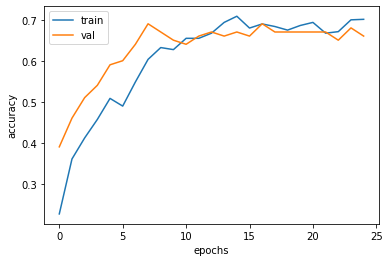

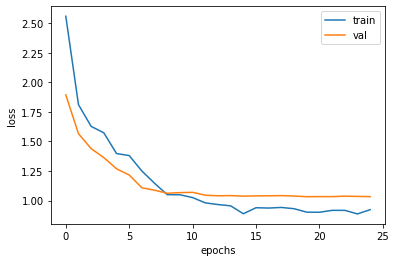

In [52]:
def plot_performance(metric, values):
  plt.plot(values['train'])
  plt.plot(values['val'])
  plt.xlabel("epochs")
  plt.ylabel(metric)
  plt.legend(values.keys())
  plt.show()

plot_performance('accuracy', accuracies)
plot_performance('loss', losses)

### Test model

In [53]:
def test_model(model):

    model.eval()   # Set model to evaluate mode

    t_output = []
    t_pred = []
    y_test = []
    top_k = []
    # Iterate over data.
    i = 1
    for inputs, labels in dataloaders['test']:
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        y_test.append(labels)

        outputs = model(inputs.float())
        _, preds = torch.max(outputs, 1)
        t_pred.append(preds)
        # temp1, temp2 = outputs.topk(5)
        # top_k.append(temp2)

    y_test = torch.cat(y_test).cpu().detach().numpy() 
    y_pred = torch.cat(t_pred).cpu().detach().numpy() 
    # y_pred = torch.cat(top_k).cpu().detach().numpy() 

    print('\nConfusion Matrix')
    conf_mt = confusion_matrix(y_test, y_pred)
    print(conf_mt)
    plt.matshow(conf_mt)
    plt.show()
    print('\nClassification Report')
    print(classification_report(y_test, y_pred, zero_division=0))


Confusion Matrix
[[ 7  0  0  1  0  0  0  0  2  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 1  2  5  0  0  0  0  0  1  1]
 [ 0  1  0  4  2  0  0  3  0  0]
 [ 0  0  0  1  9  0  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0]
 [ 0  0  0  0  1  0  9  0  0  0]
 [ 0  0  1  0  1  0  0  8  0  0]
 [ 0  0  1  1  1  0  0  1  6  0]
 [ 0  0  3  0  0  0  1  1  1  4]]


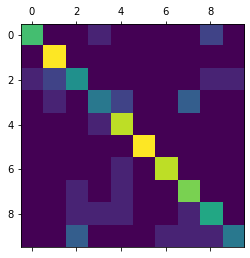


Classification Report
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.77      1.00      0.87        10
           2       0.50      0.50      0.50        10
           3       0.57      0.40      0.47        10
           4       0.64      0.90      0.75        10
           5       1.00      1.00      1.00        10
           6       0.90      0.90      0.90        10
           7       0.62      0.80      0.70        10
           8       0.60      0.60      0.60        10
           9       0.80      0.40      0.53        10

    accuracy                           0.72       100
   macro avg       0.73      0.72      0.71       100
weighted avg       0.73      0.72      0.71       100



In [54]:
test_model(model)